In [1]:
from typing import cast
from classiq import *
from classiq.execution import ExecutionPreferences
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import re

In [7]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

def pauli_str(dim, compress=True):
    A = [[0] * 2**dim for _ in range(2**dim)]
    for i in range(2**dim):
        if i >= 1:
            A[i][i-1] = -2 if i == 2**(dim-1) else -np.sqrt(2)
        A[i][i] = 3
        if i < 2**dim-1:
            A[i][i+1] = -2 if i == 2**(dim-1)-1 else -np.sqrt(2)
    A = -np.array(linalg.sqrtm(A))
    output = str(qml.pauli_decompose(np.array(A)))
    pauli = ["".join([j for j in i if j.isalpha()]) for i in re.findall(r'\[.*?\]', output)]
    consts = [float(i[1:-1]) for i in re.findall(r'\(.*?\)', output)]
    return [(pauli[i], consts[i]) for i in range(len(pauli)) if abs(consts[i]) > 1/dim**2] if compress else [(pauli[i], consts[i]) for i in range(len(pauli))]


In [18]:
def n_oscillators(dim, maxim, step):
    pauli_list = pauli_str(dim, compress=False)
    def add_point(t):
        @qfunc
        def main(state: Output[QArray[QBit]]) -> None:
            allocate(len(pauli_list[0][0]), state)
            exponentiation_with_depth_constraint(
                pauli_operator=pauli_list_to_hamiltonian(pauli_list),
                evolution_coefficient=t,
                max_depth=2000,
                qbv=state,
            )
        execution_preferences = ExecutionPreferences(num_shots=4096)
        model = set_execution_preferences(create_model(main), execution_preferences)
        quantum_program = synthesize(model)
        job = execute(quantum_program)
        results = job.result()
        return results[0].value
    times = np.arange(0, maxim, step)
    output = []
    for t in times:
        point = add_point(t)
        try:
            index = [idx for idx, s in enumerate(point.parsed_counts) if str(2**dim-1)+'.0' in str(s)][0]
            output.append(point.parsed_counts[index].shots/point.num_shots)
        except IndexError:
            output.append(0)
    plt.plot(times, output)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |"+str(2**dim-1)+"> shots")
    plt.show()

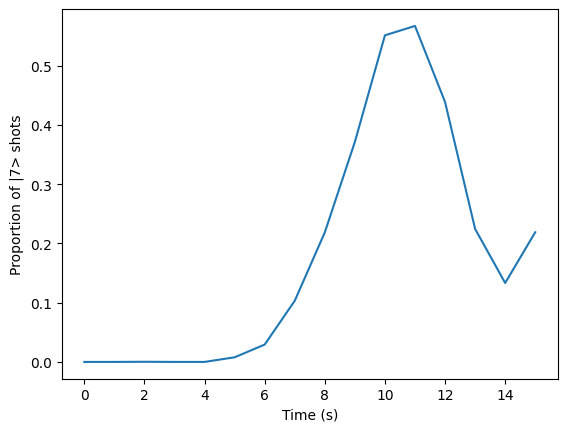

In [19]:
n_oscillators(3, 16, 1)

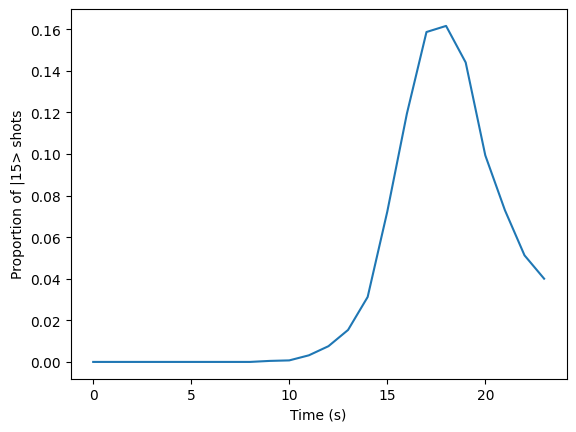

In [20]:
n_oscillators(4, 24, 1)

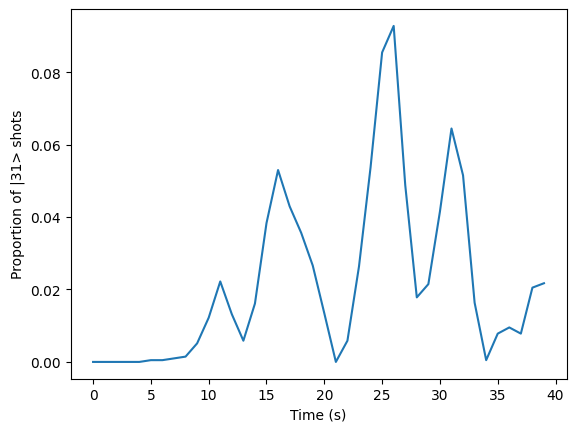

In [21]:
n_oscillators(5, 40, 1)

In [26]:
def run_point(dim, t):
    pauli_list = pauli_str(dim)
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=1000,
            qbv=state,
        )
    execution_preferences = ExecutionPreferences(num_shots=8192)
    model = set_execution_preferences(create_model(main), execution_preferences)
    quantum_program = synthesize(model)
    execute(quantum_program)

In [27]:
run_point(11, 2**11)